In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt

from mxnet import nd, autograd, gluon, init


In [4]:
n_train = 20
n_test = 100
num_inputs = 200
w_true = nd.ones((num_inputs, 1)) * 0.01
b_true = 0.05

X_data = nd.random.normal(0, 1, (n_train+n_test, num_inputs))
y_data = nd.dot(features, w_true) + b_true
y_data += nd.random.normal(0, 0.01, y_data.shape)

X_train, X_test = X_data[:n_train, :], X_data[n_train:, :]
y_train, y_test = y_data[:n_train], y_data[n_train:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20, 200) (20, 1) (100, 200) (100, 1)


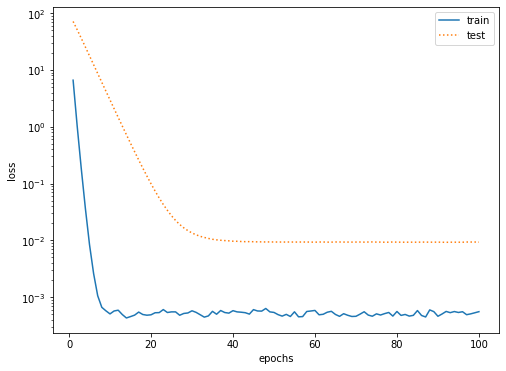

L2 norm of w: 0.042803917


In [7]:
def init_params():
    w = nd.random.normal(0, 1, (num_inputs, 1))
    b = nd.zeros((1, ))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

def l2_penalty(w):
    return (w**2).sum() / 2

def linreg(X, w, b):
    return nd.dot(X, w) + b

def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size
    return

def semilogy(
    x_vals, y_vals, 
    x_label, y_label, 
    x2_vals=None, y2_vals=None, 
    legend=None, figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()
    return 

batch_size = 1
num_epochs = 100
lr = 0.003
net = linreg
loss = squared_loss
train_iter = gluon.data.DataLoader(
    gluon.data.ArrayDataset(X_train, y_train), 
    batch_size, 
    shuffle=True
)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for ep in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(X_train, w, b), y_train).mean().asscalar())
        test_ls.append(loss(net(X_test, w, b), y_test).mean().asscalar())
    semilogy(
        range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
        range(1, num_epochs+1), test_ls,
        ['train', 'test'], 
        figsize=(8, 6)
    )
    print('L2 norm of w:', w.norm().asscalar())
    return 

# fit_and_plot(0)
fit_and_plot(3)

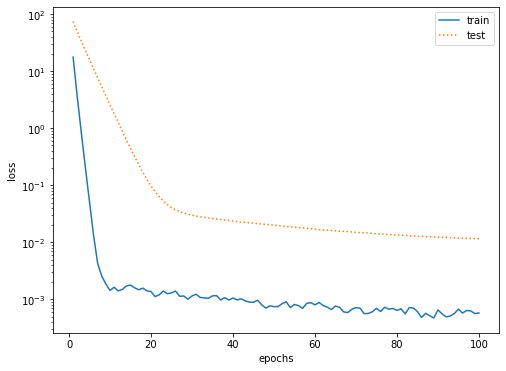

L2 norm of w: 0.04716829


In [10]:
def fit_and_plot_gluon(wd):
    net = gluon.nn.Sequential()
    net.add(gluon.nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    trainer_w = gluon.Trainer(
        net.collect_params('.*weight'), 'sgd', 
        {'learning_rate': lr, 'wd': wd}
    )
    trainer_b = gluon.Trainer(
        net.collect_params('.*bias'), 'sgd', 
        {'learning_rate': lr}
    )
    train_ls, test_ls = [], []
    for ep in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(X_train), y_train).mean().asscalar())
        test_ls.append(loss(net(X_test), y_test).mean().asscalar())
    semilogy(
        range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
        range(1, num_epochs+1), test_ls,
        ['train', 'test'], 
        figsize=(8, 6)
    )
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())
    return 

fit_and_plot_gluon(3)